# Julia でポアソン方程式を解く

[Julia](https://julialang.org/)で、以下のポアソン方程式を周期境界条件で解きます。

$$
\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2} = \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y}
$$

$$
u = \sin 2 x \\
v = \sin 2 y
$$

境界値問題を解くライブラリは、以下の3つを検討しました。  
最終的に、ドキュメントにGPUに対応しているとの記載があった[Krylov.jl](https://juliasmoothoptimizers.github.io/Krylov.jl/stable/)を選択しました。

1. [IterativeSolvers.jl](https://iterativesolvers.julialinearalgebra.org/stable/)
2. [Krylov.jl](https://juliasmoothoptimizers.github.io/Krylov.jl/stable/)
3. [KrylovKit.jl](https://jutho.github.io/KrylovKit.jl/stable/)

ライブラリをインポートします。

In [1]:
using Krylov, LinearOperators # to solve Ax=b
using CUDA # for GPU calculation
using BenchmarkTools # to evaluate calculation time
using Plots # to visualize

分割数、領域サイズ、速度場$u,v$を設定します。

In [2]:
const nx = const ny = 64
const lx = const ly = 2*pi
const atol = const rtol = 1e-5

shape = (nx, ny)
dx = lx / nx
dy = lx / ny
h = (dx, dy)
x = LinRange(0, lx, nx+1)[1:nx]
y = LinRange(0, ly, ny+1)[1:ny]

u = zeros(nx, ny)
v = zeros(nx, ny)
for j=1:ny
    for i=1:nx
        u[i,j] = sin(2 * x[i])
        v[i,j] = sin(2 * y[j])
    end
end

方程式を離散化するための2次精度中心差分法の関数を作ります。周期境界条件はここで与えます。

In [3]:
function divergence(f1, f2, h)
    df1 = 0.5 * (circshift(f1, (-1,0)) - circshift(f1, (1,0))) / h[1]
    df2 = 0.5 * (circshift(f2, (0,-1)) - circshift(f2, (0,1))) / h[2]
    return df1 + df2
end

function laplacian(f, h)
    ddf1 = (circshift(f, (-1,0)) + circshift(f, (1,0)) - 2.0*f) / h[1]^2
    ddf2 = (circshift(f, (0,-1)) + circshift(f, (0,1)) - 2.0*f) / h[2]^2
    return ddf1 + ddf2
end

laplacian (generic function with 1 method)

ポアソン方程式を $Ax=b$ の形で表現します。  
$A$は$(N_x \times N_y)^2$の巨大な疎行列になるので、配列ではなくLinearOperatorで与えます。

In [4]:
function poisson_lhs!(ddp_flatten, p_flatten, shape, h)
    p = reshape(p_flatten, shape)
    ddp_flatten = vec(laplacian(p, h))
end

lhs_ = (ddp_flatten, p_flatten) -> poisson_lhs!(ddp_flatten, p_flatten, shape, h)

b_cpu = vec(divergence(u, v, h))
A_cpu = LinearOperator(eltype(b_cpu), nx*ny, nx*ny, false, false, lhs_)

b_gpu = CuVector(b_cpu)
A_gpu = LinearOperator(eltype(b_gpu), nx*ny, nx*ny, false, false, lhs_)

Linear operator
  nrow: 4096
  ncol: 4096
  eltype: Float64
  symmetric: false
  hermitian: false
  nprod:   0
  ntprod:  0
  nctprod: 0



## Solve and Visualize

GMRES method はうまく解けています。Bi-CGSTAB method がNaNを出力する理由がわかりません。

### CPU

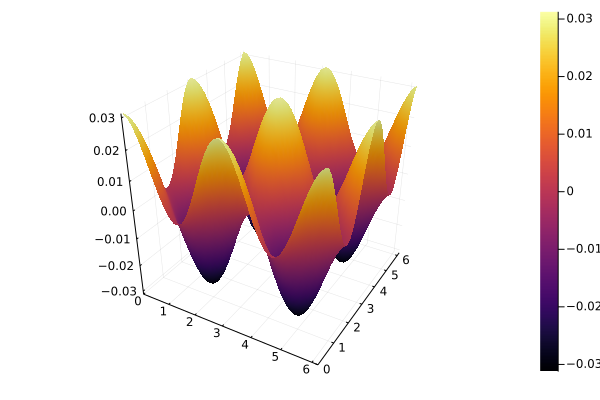

In [5]:
p_cpu_flatten, stats_cpu = gmres(A_cpu, b_cpu, atol=atol, rtol=rtol, history=true)
# p_cpu_flatten, stats = bicgstab(A_cpu, b_cpu, atol=atol, rtol=rtol, history=true)
p_cpu = reshape(p_cpu_flatten, shape)
# print(stats_cpu)
surface(x, y, p_cpu)

### GPU

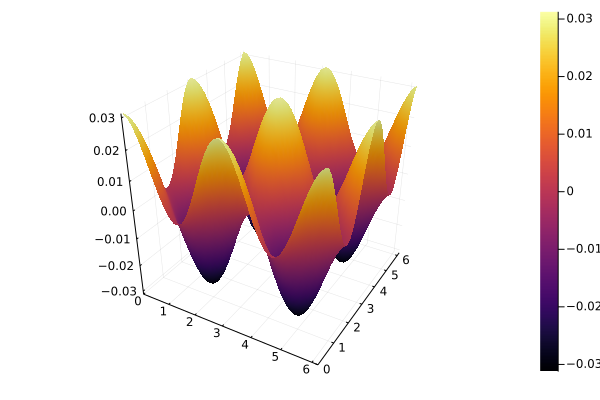

In [6]:
p_gpu_flatten, stats_gpu = gmres(A_gpu, b_gpu, atol=atol, rtol=rtol, history=true)
# p_gpu_flatten, stats_gpu = bicgstab(A_gpu, b_gpu, atol=atol, rtol=rtol, history=true)
p_gpu = reshape(p_gpu_flatten, shape)
# print(stats_gpu)
surface(x, y, Array(p_gpu))

## ベンチマーク

In [7]:
### CPU
# @benchmark gmres(A_cpu, b_cpu, atol=atol, rtol=rtol)

In [8]:
### GPU
# @benchmark gmres(A_gpu, b_gpu, atol=atol, rtol=rtol)